In [1]:
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from torchdiffeq import odeint
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:

import random
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()


In [3]:

class Encoder(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

    def forward(self, x):
        h = self.fc(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z, mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid()
        )

    def forward(self, z):
        x_recon = self.net(z)
        return x_recon.view(-1, 1, 28, 28)


In [4]:

transform = transforms.ToTensor()
mnist_train = datasets.MNIST(root="./data", train=True, transform=transform, download=False)
mnist_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)


In [5]:

def train_vae(encoder, decoder, dataloader, epochs=10, lr=1e-3):
    encoder.to(device)
    decoder.to(device)
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)

    for epoch in range(epochs):
        total_loss = 0
        for x, _ in dataloader:
            x = x.to(device)
            z, mu, logvar = encoder(x)
            x_recon = decoder(z)

            recon_loss = nn.functional.binary_cross_entropy(x_recon, x, reduction='sum')
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon_loss + kl_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % 10 == 0:
            print(f"Epoch {epoch} | VAE Loss: {total_loss / len(dataloader.dataset):.4f}")


In [6]:

encoder = Encoder(latent_dim=32)
decoder = Decoder(latent_dim=32)
train_vae(encoder, decoder, mnist_loader, epochs=30)


Epoch 0 | VAE Loss: 176.5833
Epoch 10 | VAE Loss: 102.7064
Epoch 20 | VAE Loss: 99.4089


In [7]:
train_size = int(0.9 * len(mnist_train))
val_size = len(mnist_train) - train_size
train_dataset, val_dataset = random_split(mnist_train, [train_size, val_size])

train_dataset, val_dataset = random_split(mnist_train, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

all_z = []
with torch.no_grad():
    for x, _ in train_loader:
        x = x.to(device)
        z, _, _ = encoder(x)
        all_z.append(z)
latent_data = torch.cat(all_z, dim=0)
print("Latent data shape:", latent_data.shape)

all_y = []
with torch.no_grad():
    for x, _ in val_loader:
        x = x.to(device)
        y, _, _ = encoder(x)
        all_y.append(y)
test_data = torch.cat(all_y, dim=0)
print("Test data shape:", test_data.shape)


Latent data shape: torch.Size([54000, 32])
Test data shape: torch.Size([6000, 32])


In [14]:
import torch.nn.utils as utils 
# def build_mlp(input_dim, output_dim, hidden_dim=128, num_layers=3, activation=nn.Tanh):
#     """
#     Builds a customizable Multi-Layer Perceptron (MLP).

#     Args:
#         input_dim (int): Input feature dimension.
#         output_dim (int): Output feature dimension.
#         hidden_dim (int): Number of hidden units in each hidden layer.
#         num_layers (int): Total number of layers including input and output (must be ≥ 2).
#         activation (nn.Module): Activation function (default: Tanh).

#     Returns:
#         nn.Sequential: The constructed MLP as a sequential module.
#     """
#     assert num_layers >= 2, "The network must have at least input and output layers."

#     layers = []
#     # Input layer
#     layers.append(nn.Linear(input_dim, hidden_dim))
#     layers.append(activation())

#     # Hidden layers
#     for _ in range(num_layers - 2):
#         layers.append(nn.Linear(hidden_dim, hidden_dim))
#         layers.append(activation())

#     # Output layer
#     layers.append(nn.Linear(hidden_dim, output_dim))

#     return nn.Sequential(*layers)

def build_mlp(input_dim, output_dim, hidden_dim=128, num_layers=3, activation=nn.Tanh):
    """
    Builds a customizable Multi-Layer Perceptron (MLP) with Spectral Normalization.

    Args:
        input_dim (int): Input feature dimension.
        output_dim (int): Output feature dimension.
        hidden_dim (int): Number of hidden units in each hidden layer.
        num_layers (int): Total number of layers including input and output (must be ≥ 2).
        activation (nn.Module): Activation function (default: Tanh).

    Returns:
        nn.Sequential: The constructed MLP as a sequential module.
    """
    assert num_layers >= 2, "The network must have at least input and output layers."

    layers = []

    #  Input layer with Spectral Norm
    layers.append(utils.spectral_norm(nn.Linear(input_dim, hidden_dim)))
    layers.append(activation())

    #  Hidden layers with Spectral Norm
    for _ in range(num_layers - 2):
        layers.append(utils.spectral_norm(nn.Linear(hidden_dim, hidden_dim)))
        layers.append(activation())

    #  Output layer with Spectral Norm
    layers.append(utils.spectral_norm(nn.Linear(hidden_dim, output_dim)))

    return nn.Sequential(*layers)

In [15]:
class CNFNet(nn.Module):
    def __init__(self, input_dim=32, hidden_dim=128, num_layers=4):
        super().__init__()
        self.net = build_mlp(input_dim + 1, input_dim, hidden_dim, num_layers)

    def forward(self, t, x):
        t_expand = t.expand_as(x[:, :1])
        xt = torch.cat([x, t_expand], dim=1)
        return self.net(xt)

def standard_normal_logprob(z):
    return -0.5 * (z.pow(2) + np.log(2 * np.pi)).sum(dim=1)

# def trace_df_dx(f, x, t, num_samples=4):
#     trace_total = 0
#     for _ in range(num_samples):
#         e = torch.randn_like(x)
#         e_dz = torch.autograd.grad(f(t, x), x, e, create_graph=True)[0]
#         trace_total += (e_dz * e).sum(dim=1, keepdim=True)
#     return (trace_total / num_samples).squeeze(1)

# def train_cnf(model, data, epochs=50, batch_size=256, lr=1e-3, method="rk4", lambda_trace = 0.01):
#     device = next(model.parameters()).device
#     data = data.to(device)
#     optimizer = optim.Adam(model.parameters(), lr=lr)
#     model.train()

#     for epoch in range(epochs):
#         perm = torch.randperm(data.shape[0], device=device)
#         for i in range(0, data.shape[0], batch_size):
#             idx = perm[i:i + batch_size]
#             x_T = data[idx].clone().detach().requires_grad_(True)
#             logp_T = torch.zeros(x_T.shape[0], device=device)

#             def odefunc(t, state):
#                 x, logp = state
#                 dx = model(t, x)
#                 dlogp = -trace_df_dx(model, x, t)
#                 return dx, dlogp

#             # 1. NLL loss
#             t_vals = torch.tensor([1.0, 0.0], device=device)
#             (z_0, delta_logp) = odeint(odefunc, (x_T, logp_T), t_vals, method=method,
#                                         atol=1e-5, rtol=1e-5)
#             logp_0 = standard_normal_logprob(z_0[-1])
#             logp_x = logp_0 - delta_logp[-1]
#             nll_loss = -logp_x.mean()

#             # 2. Trace Penalty
#             with torch.no_grad():
#                 trace_vals = trace_df_dx(model, x_T, t=torch.tensor(1.0, device=device))
#                 trace_penalty = (trace_vals ** 2).mean()
            
#             total_loss = nll_loss + lambda_trace * trace_penalty
#             optimizer.zero_grad()
#             total_loss.backward()
#             optimizer.step()
#         if epoch % 10 == 0:
#                 print(f"[CNF] Epoch {epoch} | Loss: {total_loss.item():.4f}")
def trace_df_dx(f, x, t):
    e = torch.randn_like(x)
    e_dz = torch.autograd.grad(f(t, x), x, e, create_graph=True)[0]
    return (e_dz * e).sum(dim=1)

def train_cnf(model, data, epochs=50, batch_size=256, lr=1e-3, method="rk4"):
    device = next(model.parameters()).device
    data = data.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        perm = torch.randperm(data.shape[0], device=device)
        for i in range(0, data.shape[0], batch_size):
            idx = perm[i:i + batch_size]
            x_T = data[idx].clone().detach().requires_grad_(True)
            logp_T = torch.zeros(x_T.shape[0], device=device)

            def odefunc(t, state):
                x, logp = state
                dx = model(t, x)
                dlogp = -trace_df_dx(model, x, t)
                return dx, dlogp

            t_vals = torch.tensor([1.0, 0.0], device=device)
            (z_0, delta_logp) = odeint(odefunc, (x_T, logp_T), t_vals, method=method,
                                        atol=1e-5, rtol=1e-5)
            logp_0 = standard_normal_logprob(z_0[-1])
            logp_x = logp_0 - delta_logp[-1]
            loss = -logp_x.mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print(f"[CNF] Epoch {epoch} | NLL: {loss.item():.4f}")

In [16]:
def sample_from_cnf_and_decode(cnf_model, decoder, n_samples=64):
    cnf_model.eval()
    decoder.eval()
    with torch.no_grad():
        z0 = torch.randn(n_samples, 32).to(device)

        def odefunc(t, x):
            return cnf_model(t, x)

        t_vals = torch.tensor([0.0, 1.0], device=device)
        z_T = odeint(odefunc, z0, t_vals)[-1]

        recon = decoder(z_T).cpu()
        return recon

def show_images_CNF(images, nrow=8, save_path = "generated_samples.png"):
    images = images.view(-1, 1, 28, 28)
    grid = torchvision.utils.make_grid(images, nrow=nrow)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).squeeze())
    plt.axis("off")
    plt.title("Generated Images from CNF + Decoder")
    plt.savefig(save_path, dpi=300)
    print(f"Image saved to {save_path}")
    plt.show()   

In [17]:
class RFStudent(nn.Module):
    def __init__(self, dim=32, hidden_dim=128, num_layers=3):
        super().__init__()
        self.net = build_mlp(dim + 1, dim, hidden_dim, num_layers)

    def forward(self, t, x):
        if len(t.shape) == 0:
            t = t.expand(x.shape[0], 1)
        elif len(t.shape) == 1:
            t = t.unsqueeze(1)
        tx = torch.cat([x, t], dim=1)
        return self.net(tx)
def train_rf_student(cnf_model, student, source_data, epochs=50, batch_size=256, num_steps=20, lr=1e-3):
    device = next(cnf_model.parameters()).device
    cnf_model.eval()
    # Construct the trajectory from the teacher model
    t_vals = torch.linspace(0.0, 1.0, num_steps).to(device)
    z0 = source_data.to(device)

    with torch.no_grad():
        trajectory = odeint(cnf_model, z0, t_vals, method="rk4")

    t_samples, x_samples, v_samples = [], [], []

    for i in range(num_steps):
        t_i = t_vals[i]
        x_i = trajectory[i]
        with torch.no_grad():
            v_i = cnf_model(t_i, x_i)

        t_samples.append(t_i.expand(x_i.shape[0]))
        x_samples.append(x_i)
        v_samples.append(v_i)

    t_train = torch.cat(t_samples, dim=0)
    x_train = torch.cat(x_samples, dim=0)
    v_train = torch.cat(v_samples, dim=0)

    dataset = TensorDataset(t_train, x_train, v_train)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam(student.parameters(), lr=lr)
    for epoch in range(epochs):
        for t_b, x_b, v_b in loader:
            t_b, x_b, v_b = t_b.to(device), x_b.to(device), v_b.to(device)
            pred_v = student(t_b, x_b)
            loss = ((pred_v - v_b) ** 2).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print(f"[RF] Epoch {epoch} | Loss: {loss.item():.4f}")

    return student

def sample_from_rf_and_decode(rf_model, decoder, n_samples=64, num_steps=20):
    device = next(rf_model.parameters()).device
    rf_model.eval()
    decoder.eval()

    with torch.no_grad():
        z = torch.randn(n_samples, 32).to(device)
        dt = 1.0 / num_steps
        t = torch.zeros(n_samples, 1).to(device)

        for _ in range(num_steps):
            v = rf_model(t.squeeze(1), z)
            z = z + dt * v
            t += dt

        recon = decoder(z).cpu()
        return recon

def show_images_RF(images, nrow=8, save_path = "generated_samples.png"):
    images = images.view(-1, 1, 28, 28)
    grid = torchvision.utils.make_grid(images, nrow=nrow)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).squeeze())
    plt.axis("off")
    plt.title("Generated Images from CNF + Decoder")
    plt.savefig(save_path, dpi=300)
    print(f"Image saved to {save_path}")
    plt.show()   


In [18]:
cnf_model = CNFNet(input_dim=32, num_layers = 3).to(device)
train_cnf(cnf_model, latent_data, epochs = 220, lr=1e-4, method="rk4")


[CNF] Epoch 0 | NLL: 45.4427
[CNF] Epoch 10 | NLL: 45.4028
[CNF] Epoch 20 | NLL: 45.1565
[CNF] Epoch 30 | NLL: 45.5961
[CNF] Epoch 40 | NLL: 45.2201
[CNF] Epoch 50 | NLL: 45.4306
[CNF] Epoch 60 | NLL: 45.2710
[CNF] Epoch 70 | NLL: 45.1468
[CNF] Epoch 80 | NLL: 45.3636
[CNF] Epoch 90 | NLL: 45.0559
[CNF] Epoch 100 | NLL: 45.3051
[CNF] Epoch 110 | NLL: 45.2240
[CNF] Epoch 120 | NLL: 45.4438
[CNF] Epoch 130 | NLL: 44.7850
[CNF] Epoch 140 | NLL: 45.1221
[CNF] Epoch 150 | NLL: 45.0319
[CNF] Epoch 160 | NLL: 45.0469
[CNF] Epoch 170 | NLL: 45.1852
[CNF] Epoch 180 | NLL: 44.9564
[CNF] Epoch 190 | NLL: 45.1031
[CNF] Epoch 200 | NLL: 45.1864
[CNF] Epoch 210 | NLL: 44.6852


Image saved to generated_samples.png


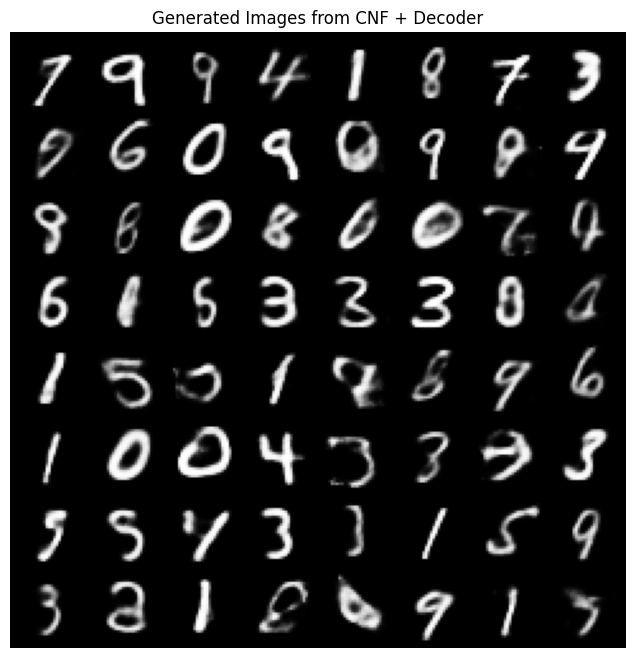

In [19]:
samples = sample_from_cnf_and_decode(cnf_model, decoder, n_samples=64)
show_images_CNF(samples)



===== Starting Reflow Round 1 =====
[RF] Epoch 0 | Loss: 0.0104
[RF] Epoch 10 | Loss: 0.0038
[RF] Epoch 20 | Loss: 0.0034
[RF] Epoch 30 | Loss: 0.0026
[RF] Epoch 40 | Loss: 0.0013
[RF] Epoch 50 | Loss: 0.0011
[RF] Epoch 60 | Loss: 0.0007
[RF] Epoch 70 | Loss: 0.0006
[RF] Epoch 80 | Loss: 0.0004
[RF] Epoch 90 | Loss: 0.0005
[RF] Epoch 100 | Loss: 0.0004
[RF] Epoch 110 | Loss: 0.0003
[RF] Epoch 120 | Loss: 0.0003
[RF] Epoch 130 | Loss: 0.0003
[RF] Epoch 140 | Loss: 0.0003
[RF] Epoch 150 | Loss: 0.0003
[RF] Epoch 160 | Loss: 0.0003
[RF] Epoch 170 | Loss: 0.0003
[RF] Epoch 180 | Loss: 0.0003
[RF] Epoch 190 | Loss: 0.0003
Image saved to reflow_round_1.png


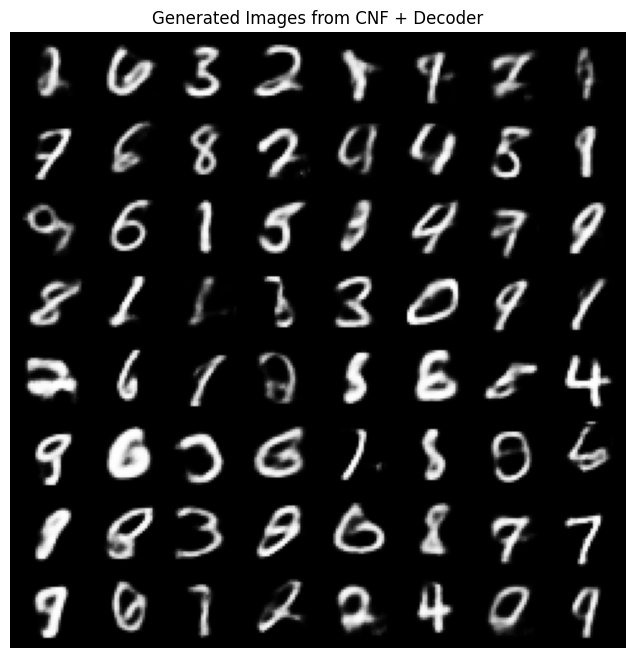

In [20]:
student = RFStudent(dim=32, hidden_dim=128, num_layers=2).to(device)
teacher = cnf_model.to(device)
for round_idx in range(1):  
    print(f"\n===== Starting Reflow Round {round_idx + 1} =====")

    source_data = torch.randn(5000, 32).to(device)

    student = train_rf_student(teacher, student=student, source_data=source_data, epochs=200, batch_size=256, lr=1e-4, num_steps=20)

    samples = sample_from_rf_and_decode(student, decoder, n_samples=64)
    show_images_RF(samples, save_path=f"reflow_round_{round_idx+1}.png")

    teacher = student


In [21]:
import time
rf_model = teacher
def benchmark_inference_times(model_type, sample_sizes, num_trials=5):
    times = []
    for n_samples in sample_sizes:
        total_time = 0.0
        for _ in range(num_trials):
            z0 = torch.randn(n_samples, 32).to(device)

            start = time.time()
            if model_type == "cnf":
                _ = sample_from_cnf_and_decode(cnf_model, decoder, n_samples=n_samples)
            elif model_type == "rf":
                _ = sample_from_rf_and_decode(rf_model, decoder, n_samples=n_samples)
            total_time += time.time() - start

        avg_time = total_time / num_trials
        print(f"[{model_type.upper()}] Avg inference time over {num_trials} trials for {n_samples} samples: {avg_time:.4f}s")
        times.append(avg_time) 
    return times



In [22]:
sample_sizes = [10**i for i in range(1, 6)]  # [10, 100, 1000, 10000, 100000]
cnf_times = benchmark_inference_times("cnf", sample_sizes, num_trials = 50)
rf_times = benchmark_inference_times("rf", sample_sizes, num_trials = 50)



[CNF] Avg inference time over 50 trials for 10 samples: 0.0571s
[CNF] Avg inference time over 50 trials for 100 samples: 0.0587s
[CNF] Avg inference time over 50 trials for 1000 samples: 0.0590s
[CNF] Avg inference time over 50 trials for 10000 samples: 0.1764s
[CNF] Avg inference time over 50 trials for 100000 samples: 1.5169s
[RF] Avg inference time over 50 trials for 10 samples: 0.0126s
[RF] Avg inference time over 50 trials for 100 samples: 0.0113s
[RF] Avg inference time over 50 trials for 1000 samples: 0.0131s
[RF] Avg inference time over 50 trials for 10000 samples: 0.0455s
[RF] Avg inference time over 50 trials for 100000 samples: 0.4546s


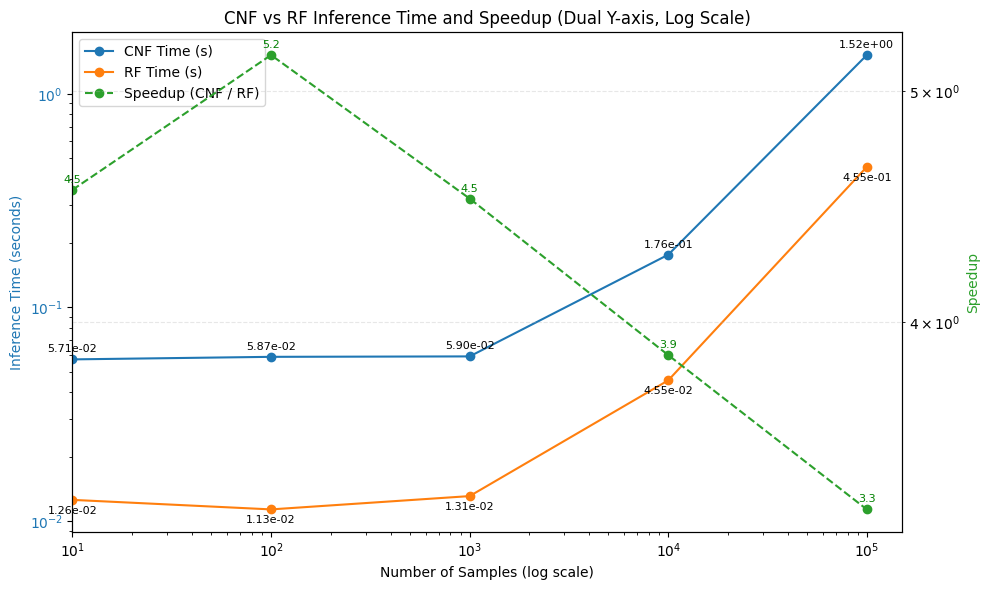

In [23]:
plt.figure(figsize=(10, 6))
speedups = [c / r for c, r in zip(cnf_times, rf_times)]
# Left Y-axis: Inference times
ax1 = plt.gca()
ln1 = ax1.plot(sample_sizes, cnf_times, label='CNF Time (s)', marker='o', color='tab:blue')
ln2 = ax1.plot(sample_sizes, rf_times, label='RF Time (s)', marker='o', color='tab:orange')
ax1.set_xlabel("Number of Samples (log scale)")
ax1.set_ylabel("Inference Time (seconds)", color='tab:blue')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(min(sample_sizes), max(sample_sizes) * 1.5)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Right Y-axis: Speedup (CNF / RF)
ax2 = ax1.twinx()
ln3 = ax2.plot(sample_sizes, speedups, label='Speedup (CNF / RF)', marker='o', linestyle='--', color='tab:green')
ax2.set_ylabel("Speedup", color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.set_yscale('log')

# Annotate points
for x, y in zip(sample_sizes, cnf_times):
    ax1.annotate(f"{y:.2e}", (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

for x, y in zip(sample_sizes, rf_times):
    ax1.annotate(f"{y:.2e}", (x, y), textcoords="offset points", xytext=(0, -10), ha='center', fontsize=8)

for x, y in zip(sample_sizes, speedups):
    ax2.annotate(f"{y:.1f}", (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='green')

# Legend
lines = ln1 + ln2 + ln3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper left")

plt.title("CNF vs RF Inference Time and Speedup (Dual Y-axis, Log Scale)")
plt.grid(True, which="both", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

In [24]:
from torchvision.utils import save_image

# Setup
real_dir = "./data/real_mnist"
os.makedirs(real_dir, exist_ok=True)
real_loader = torch.utils.data.DataLoader(mnist_train, batch_size=1, shuffle=True)


# Save only 100 real images
num_images_to_save = 3000
for i, (img, _) in tqdm(enumerate(real_loader), total=num_images_to_save, desc="Saving 3000 real MNIST images"):
    save_image(img, os.path.join(real_dir, f"{i:05d}.png"))
    if i >= num_images_to_save - 1:
        break

Saving 3000 real MNIST images: 100%|█████████▉| 2999/3000 [00:03<00:00, 987.35it/s] 


In [25]:
def generate_fake_images(model_type='rf', start_idx=0, count=100, latent_dim=32, save_dir="/mnt/data/fake_mnist_rf"):
    """
    Generate and save fake MNIST-style images using CNF or RF.

    Args:
        model_type (str): 'rf' or 'cnf'
        start_idx (int): starting index for saved image filenames
        count (int): number of images to generate
        latent_dim (int): dimension of latent vector
        save_dir (str): directory to save images
    """
    assert model_type in ['rf', 'cnf'], "model_type must be 'rf' or 'cnf'"
    os.makedirs(save_dir, exist_ok=True)

    model = rf_model if model_type == 'rf' else cnf_model
    model.eval()
    decoder.eval()

    num_steps = 20
    dt = 1.0 / num_steps

    with torch.no_grad():
        for i in range(count):
            z = torch.randn(1, latent_dim).to(device)

            if model_type == 'rf':
                t = torch.zeros(1, 1).to(device)
                for _ in range(num_steps):
                    v = model(t.squeeze(1), z)
                    z = z + dt * v
                    t += dt
                zt = z
            else:  # CNF
                from torchdiffeq import odeint
                t_span = torch.tensor([0.0, 1.0]).to(device)
                zt = odeint(model, z, t_span)[-1]

            x = decoder(zt)
            save_path = os.path.join(save_dir, f"{start_idx + i:05d}.png")
            save_image(x, save_path)

    print(f"Saved {count} fake images to {save_dir} using {model_type.upper()}")


In [26]:
# First batch of RF images
generate_fake_images(model_type='rf', start_idx=0, count=3000, save_dir="./data/fake_mnist_rf")

# First batch of CNF images
generate_fake_images(model_type='cnf', start_idx=0, count=3000, save_dir="./data/fake_mnist_cnf")


Saved 3000 fake images to ./data/fake_mnist_rf using RF
Saved 3000 fake images to ./data/fake_mnist_cnf using CNF


In [27]:
import torch
import torchvision
import torchvision.transforms as transforms
from pytorch_fid import fid_score

# Prepare the real images and generated images
real_images_folder = './data/real_mnist'
generated_images_folder_cnf = './data/fake_mnist_cnf'
generated_images_folder_rf = './data/fake_mnist_rf'

# Load the pretrained model Inception-v3
inception_model = torchvision.models.inception_v3(pretrained=True)




# Calculate the FID score
fid_value_cnf = fid_score.calculate_fid_given_paths(
    paths=[real_images_folder, generated_images_folder_cnf],
    batch_size=64,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    dims=2048
)


fid_value_rf = fid_score.calculate_fid_given_paths(
    paths=[real_images_folder, generated_images_folder_rf],
    batch_size=64,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    dims=2048
)



c:\Users\Starry\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Starry\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 47/47 [01:17<00:00,  1.65s/it]


In [28]:
print('FID value of CNF:', fid_value_cnf)
print('FID value of RF:', fid_value_rf)

FID value of CNF: 25.96155907731753
FID value of RF: 26.584363167202667


In [29]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model parameter count: {count_parameters(cnf_model)}")
print(f"Model parameter count: {count_parameters(teacher)}")

Model parameter count: 24992
Model parameter count: 8480


In [31]:
def estimate_log_likelihood(cnf_model, z_T, atol=1e-4, rtol=1e-4):
    z_T = z_T.to(next(cnf_model.parameters()).device).requires_grad_(True)
    logp_T = torch.zeros(z_T.shape[0], device=z_T.device)

    def odefunc(t, state):
        z, logp = state
        dz = cnf_model(t, z)
        with torch.enable_grad():
            v = torch.randn_like(z)
            Jv = torch.autograd.grad(dz, z, v, create_graph=True)[0]
            trace = (Jv * v).sum(dim=1)
        return dz, -trace

    t_vals = torch.tensor([1.0, 0.0], device=z_T.device)
    z0, delta_logp = odeint(odefunc, (z_T, logp_T), t_vals, atol=atol, rtol=rtol)

    logp_0 = -0.5 * (z0[-1] ** 2 + np.log(2 * np.pi)).sum(dim=1)
    return logp_0 - delta_logp[-1]

def compare_density_and_time(cnf_model, rf_model, latent_dim=32, num_steps=20, batch_size=1000):
    device = next(cnf_model.parameters()).device
    z0_shared = torch.randn(batch_size, latent_dim).to(device)


    # -------------------------------
    # CNF 原生采样 + 评分
    # -------------------------------
    start_cnf = time.time()
    z0_cnf = z0_shared.clone()
    t_vals = torch.tensor([0.0, 1.0]).to(device)

    
    zT_cnf = odeint(cnf_model, z0_cnf, t_vals)[-1]
    logp_cnf = estimate_log_likelihood(cnf_model, zT_cnf)
    time_cnf = time.time() - start_cnf

    # -------------------------------
    # RF 采样 + CNF 评分
    # -------------------------------
    start_rf = time.time()
    z0_rf = z0_shared.clone()
    z_rf = z0_rf.clone()
    t_rf = torch.zeros(batch_size, 1).to(device)
    dt = 1.0 / num_steps

    
    for _ in range(num_steps):
        v = rf_model(t_rf, z_rf)
        z_rf = z_rf + dt * v
        t_rf += dt
    logp_rf = estimate_log_likelihood(cnf_model, z_rf)
    time_rf = time.time() - start_rf

    # -------------------------------
    # 输出对比结果
    # -------------------------------
    print(f"CNF: Avg logp = {logp_cnf.mean():.4f}, Time = {time_cnf:.2f}s")
    print(f"RF:  Avg logp = {logp_rf.mean():.4f}, Time = {time_rf:.2f}s")

    # -------------------------------
    # 可视化对比
    # -------------------------------
    plt.hist(logp_cnf.detach().cpu().numpy(), bins=50, alpha=0.5, label="CNF")
    plt.hist(logp_rf.detach().cpu().numpy(), bins=50, alpha=0.5, label="RF + CNF")
    plt.xlabel("Log-likelihood")
    plt.ylabel("Count")
    plt.title("Log-likelihood Distribution Comparison")
    plt.legend()
    plt.show()

In [115]:
# compare_density_and_time(cnf_model, rf_model, latent_dim=32, num_steps=20, batch_size=0)

In [30]:
print(torch.cuda.memory_allocated() / 1024**2, "MB allocated")
print(torch.cuda.memory_reserved() / 1024**2, "MB reserved")


40.9169921875 MB allocated
2590.0 MB reserved
